In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
5531    0
5532    0
5533    0
5534    0
5535    0
Name: mon_1, Length: 5536, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=26))
df=df.set_index(["id","year_month"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2188 entries, (114, Timestamp('2009-11-26 00:00:00')) to (799, Timestamp('2022-12-26 00:00:00'))
Columns: 126 entries, year to year_trend
dtypes: float64(14), int32(3), int64(91), object(6), uint8(12)
memory usage: 1.9+ MB


(126, 167, 26)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
# formula="rx_dom ~ +elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# # stock lag
# # formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_rx_lag+TimeEffects+EntityEffects"

# # with month dummies
# # formula+=months

# # ytrend
# # formula+=ytrend

# # mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# # drop_absorbed=True
# mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# # print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="rx_mon",title="rx_mon")

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elasped_m10         -0.3320     0.3264    -1.0173     0.3091     -0.9721      0.3080
elasped_m9          -0.4075     0.2980    -1.3672     0.1717     -0.9919      0.1770
elasped_m8          -0.3078     0.2126    -1.4482     0.1477     -0.7247      0.1091
elasped_m7          -0.3832     0.2927    -1.3091     0.1907     -0.9572      0.1909
elasped_m6          -0.3604     0.2283    -1.5785     0.1146     -0.8082      0.0874
elasped_m5          -0.1183     0.1439    -0.8220     0.4112     -0.4006      0.1640
elasped_m4          -0.3212     0.1953    -1.6443     0.1003     -0.7043      0.0619
elasped_m3          -0.0311     0.1357    -0.2289     0.8190     -0.2972      0.2351
elasped_m2          -0.1157     0.0725    -1.5957     0.1107     

C:\Users\hakos\AppData\Local\Temp\ipykernel_12840\2029733755.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rx_dom   R-squared:                        0.1031
Estimator:                   PanelOLS   R-squared (Between):              0.1407
No. Observations:                2188   R-squared (Within):               0.0648
Date:                Thu, Sep 07 2023   R-squared (Overall):              0.1332
Time:                        00:11:52   Log-likelihood                   -804.53
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.0783
Entities:                          26   P-value                           0.0000
Avg Obs:                       84.154   Distribution:                 F(28,1968)
Min Obs:                       47.000                                           
Max Obs:                       167.00   F-statistic (robust):          6.457e+14
                            

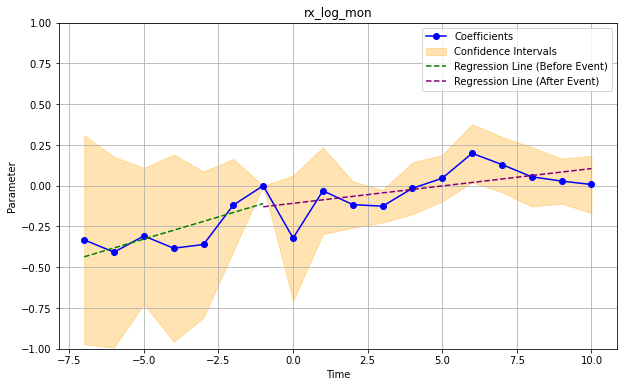

In [8]:
# take log
formula="log_rx_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version and month dummies
# formula="log_rx_dom ~ generic_per+log_stock_rx_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# with months
# formula+=months

# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon")

### OTC

In [9]:

# formula="otc_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"


# # stock lag only
# # formula+="+stock_otc_lag"

# # # with months
# # formula+=months

# # # ytrend
# # formula+=ytrend


# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="otc_mon",title="otc_mon")

C:\Users\hakos\AppData\Local\Temp\ipykernel_12840\1564310108.py:29: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elasped_m10          -0.4781     0.7630    -0.6266     0.5310     -1.9746      1.0183
elasped_m9           -1.6472     1.1595    -1.4207     0.1556     -3.9212      0.6267
elasped_m8           -1.9886     1.1945    -1.6648     0.0961     -4.3312      0.3540
elasped_m7           -3.1188     1.2533    -2.4885     0.0129     -5.5768     -0.6609
elasped_m6           -1.5105     1.1074    -1.3641     0.1727     -3.6822      0.6612
elasped_m5           -2.3701     1.1304    -2.0966     0.0362     -4.5871     -0.1531
elasped_m4           -1.6113     0.8027    -2.0075     0.0448     -3.1854     -0.0372
elasped_m3           -1.1301     0.5738    -1.9694     0.0490     -2.2554     -0.0047
elasped_m2           -0.1325     0.2940    -0.4506    

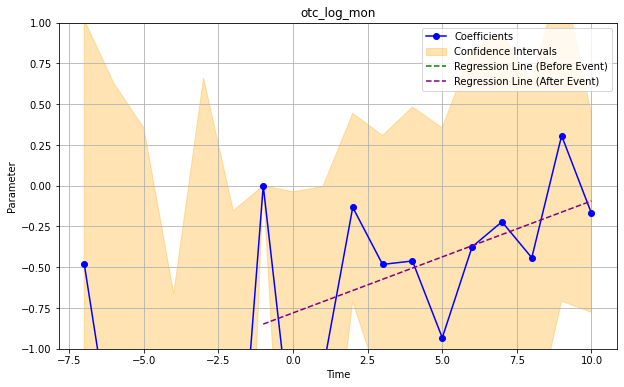

In [10]:
# take log

# till 20
# formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15"

# gemeric_per
formula+=" + generic_per"

# fixed effects
formula+=" + EntityEffects + TimeEffects"

# add lagged stock
formula+="+log_stock_otc_lag"

# with month dummies
# formula+=months

# ytrend
# formula+=ytrend

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon")